# Dropoutを試してみる
過学習を防ぐ仕組みとしてweight decayは簡単に実装できるのだが、ニューラルネットワークのモデルが複雑になるとweight decayでは対応できなくなるとのこと。Dropoutはニューラルネットワークのニューロンをランダムに消去することで、信号の伝達を遮断することで、過学習を防ぐというもの
1. 訓練時：データが流れる度にニューロンをランダムに選択して消去する
2. テスト時：すべてのニューロンの信号を伝達するが、各ニューロンの出力に対して訓練時に消去した割合を乗算して出力する

In [1]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD, Adam
#%matplotlib notebook

## 実装を見て理解する

### Dropoutクラス本体

In [2]:
class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

試行"deep-learning-from-scratch/my_jupyter/numpy_excersice.ipynb"に記載のあるとおり、numpyの性質を上手く使ってmaskを掛けている。
forward時では入力行列(x)からランダムに要素を消す。この時に、消した要素の位置を覚えておき(self.mask)、
backward時にはそれを利用して、逆伝搬してきた要素と同じ位置の要素を消す。

### レイヤの位置
テキストのMultiLayerNetExtendクラスの実装を見てみる。

In [3]:
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0, 
                 use_dropout = False, dropout_ration = 0.5, use_batchnorm=False):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.use_dropout = use_dropout
        self.weight_decay_lambda = weight_decay_lambda
        self.use_batchnorm = use_batchnorm
        self.params = {}

        # 重みの初期化
        self.__init_weight(weight_init_std)

        # レイヤの生成
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            if self.use_batchnorm:
                self.params['gamma' + str(idx)] = np.ones(hidden_size_list[idx-1])
                self.params['beta' + str(idx)] = np.zeros(hidden_size_list[idx-1])
                self.layers['BatchNorm' + str(idx)] = BatchNormalization(self.params['gamma' + str(idx)], self.params['beta' + str(idx)])
                
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()
            
            if self.use_dropout: #★ここ！
                self.layers['Dropout' + str(idx)] = Dropout(dropout_ration)

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

コメントの記しているところ（★ここ！の部分）がdropoutの挿入箇所である。隠れ層毎にアクティベーションレイヤが終わった後に、Dropoutを行っている。また、最後でAffineをしてSoftmaxWithLossを実施している。これはBatchNormalizationと同じ。要するにDropoutはBatchNormalizationに上手く挿入することができるというコトである。ここに、ニューラルネットワークの上手いモジュール性が活かされていることが良くわかる。

## 実際に動かしてみる。
テキストの実験コードをコピペして動かしてみる("ch06/overfit_dropout.py")

In [6]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

def trial(use_dropout=True, dropout_ratio=0.2):
    (x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

    # 過学習を再現するために、学習データを削減
    x_train = x_train[:300]
    t_train = t_train[:300]

    # Dropuoutの有無、割り合いの設定 ========================
    #use_dropout = True  # Dropoutなしのときの場合はFalseに
    #dropout_ratio = 0.2
    # ====================================================

    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                                  output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
    trainer = Trainer(network, x_train, t_train, x_test, t_test,
                      epochs=301, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
    trainer.train()

    train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

    # グラフの描画==========
    markers = {'train': 'o', 'test': 's'}
    x = np.arange(len(train_acc_list))
    plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
    plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.ylim(0, 1.0)
    plt.legend(loc='lower right')
    plt.figure()
    plt.show()


train loss:2.3075257053444305
=== epoch:1, train acc:0.10666666666666667, test acc:0.0914 ===
train loss:2.28090672955925
train loss:2.301476446437571
train loss:2.2913174416105964
=== epoch:2, train acc:0.11, test acc:0.0932 ===
train loss:2.3071096225837726
train loss:2.298518210787746
train loss:2.3030143094924127
=== epoch:3, train acc:0.11, test acc:0.0947 ===
train loss:2.2805561406033434
train loss:2.2966089404931664
train loss:2.290722232077873
=== epoch:4, train acc:0.11, test acc:0.0961 ===
train loss:2.2981981942529495
train loss:2.297808462371442
train loss:2.2962521180034092
=== epoch:5, train acc:0.10666666666666667, test acc:0.096 ===
train loss:2.284139243356933
train loss:2.2895800706043308
train loss:2.3017954699432392
=== epoch:6, train acc:0.11333333333333333, test acc:0.0984 ===
train loss:2.27750479157615
train loss:2.306244802196673
train loss:2.299318148677594
=== epoch:7, train acc:0.11, test acc:0.0987 ===
train loss:2.274799047157314
train loss:2.303058994600

=== epoch:57, train acc:0.2733333333333333, test acc:0.2361 ===
train loss:2.254380243866072
train loss:2.2253471438083214
train loss:2.237095014344229
=== epoch:58, train acc:0.27666666666666667, test acc:0.2379 ===
train loss:2.2355571965047747
train loss:2.2293820015932053
train loss:2.267172585624678
=== epoch:59, train acc:0.27666666666666667, test acc:0.2388 ===
train loss:2.238206353140479
train loss:2.2717355032418296
train loss:2.2220172795551907
=== epoch:60, train acc:0.2833333333333333, test acc:0.2401 ===
train loss:2.252370865811189
train loss:2.232117926324153
train loss:2.2484249607086473
=== epoch:61, train acc:0.2833333333333333, test acc:0.2413 ===
train loss:2.2412046677548254
train loss:2.2506377222667076
train loss:2.2555284704085063
=== epoch:62, train acc:0.2833333333333333, test acc:0.2429 ===
train loss:2.2441129144471335
train loss:2.246320164411244
train loss:2.232228410921735
=== epoch:63, train acc:0.2833333333333333, test acc:0.2438 ===
train loss:2.25531

=== epoch:114, train acc:0.31666666666666665, test acc:0.2693 ===
train loss:2.1532276816021136
train loss:2.1249289761112697
train loss:2.172227224058181
=== epoch:115, train acc:0.32666666666666666, test acc:0.2715 ===
train loss:2.1363520025382328
train loss:2.1528737486462637
train loss:2.161121877684097
=== epoch:116, train acc:0.32666666666666666, test acc:0.2713 ===
train loss:2.1608423916618666
train loss:2.146780668211337
train loss:2.1682290008606198
=== epoch:117, train acc:0.3233333333333333, test acc:0.2722 ===
train loss:2.15443995658285
train loss:2.1541541049081654
train loss:2.1842728079547675
=== epoch:118, train acc:0.32666666666666666, test acc:0.2721 ===
train loss:2.15506293870734
train loss:2.158996959393529
train loss:2.125400830145363
=== epoch:119, train acc:0.3333333333333333, test acc:0.2759 ===
train loss:2.1425011431540972
train loss:2.1805450431387188
train loss:2.174471526308983
=== epoch:120, train acc:0.3333333333333333, test acc:0.2783 ===
train loss:

=== epoch:170, train acc:0.36, test acc:0.3037 ===
train loss:1.9524050893767448
train loss:1.999317123047018
train loss:1.9849874935174583
=== epoch:171, train acc:0.36333333333333334, test acc:0.3066 ===
train loss:1.9385321591002844
train loss:1.9857638894928251
train loss:1.9851219402696267
=== epoch:172, train acc:0.36666666666666664, test acc:0.3095 ===
train loss:1.9835730186559488
train loss:1.9653640979105245
train loss:2.001200788673517
=== epoch:173, train acc:0.37, test acc:0.3126 ===
train loss:1.9587402237332248
train loss:1.9146782480365476
train loss:1.949269005116105
=== epoch:174, train acc:0.37, test acc:0.3121 ===
train loss:1.89550251551147
train loss:1.9453243805105114
train loss:1.8507151401491677
=== epoch:175, train acc:0.37, test acc:0.3142 ===
train loss:1.8587510855775797
train loss:1.8764459450853448
train loss:1.9316551946943403
=== epoch:176, train acc:0.37, test acc:0.3132 ===
train loss:1.9172776017662592
train loss:1.8850627753981868
train loss:1.84699

=== epoch:227, train acc:0.45666666666666667, test acc:0.364 ===
train loss:1.6694700235868447
train loss:1.7993891074904287
train loss:1.713357120240825
=== epoch:228, train acc:0.46, test acc:0.3659 ===
train loss:1.5655189912552445
train loss:1.6752869204081364
train loss:1.6916058581142182
=== epoch:229, train acc:0.46, test acc:0.365 ===
train loss:1.692019653132919
train loss:1.8013370035187168
train loss:1.820135388526286
=== epoch:230, train acc:0.4633333333333333, test acc:0.3655 ===
train loss:1.6844625467334315
train loss:1.7249225426536026
train loss:1.6718562320393489
=== epoch:231, train acc:0.46, test acc:0.3669 ===
train loss:1.6936553601794415
train loss:1.6732576869413143
train loss:1.6700920079936585
=== epoch:232, train acc:0.47, test acc:0.3693 ===
train loss:1.7069089376050146
train loss:1.6426499606066889
train loss:1.7066663599229601
=== epoch:233, train acc:0.47333333333333333, test acc:0.3691 ===
train loss:1.771273630159515
train loss:1.614496704301255
train 

=== epoch:283, train acc:0.5433333333333333, test acc:0.44 ===
train loss:1.3728876569926347
train loss:1.4765986162682028
train loss:1.4677787665521533
=== epoch:284, train acc:0.5466666666666666, test acc:0.4414 ===
train loss:1.396648282278091
train loss:1.5169986101285549
train loss:1.4701804369330735
=== epoch:285, train acc:0.55, test acc:0.4422 ===
train loss:1.3756967903623707
train loss:1.5085066306939816
train loss:1.318065030953425
=== epoch:286, train acc:0.5433333333333333, test acc:0.4415 ===
train loss:1.450655869379826
train loss:1.4213318189999864
train loss:1.385577460873856
=== epoch:287, train acc:0.55, test acc:0.4447 ===
train loss:1.2687189168555681
train loss:1.374879595364272
train loss:1.5256631927939714
=== epoch:288, train acc:0.5466666666666666, test acc:0.4459 ===
train loss:1.4593473104328387
train loss:1.3740088340657035
train loss:1.2725565160144736
=== epoch:289, train acc:0.5433333333333333, test acc:0.4466 ===
train loss:1.419089952099241
train loss:

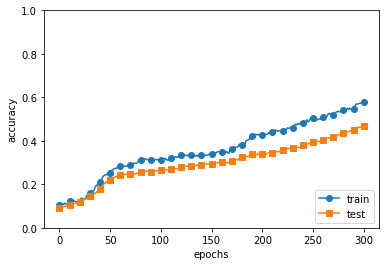

<Figure size 432x288 with 0 Axes>

In [7]:
trial()

train loss:2.313170695129644
=== epoch:1, train acc:0.09666666666666666, test acc:0.0997 ===
train loss:2.3460776203458673
train loss:2.327002475775741
train loss:2.312442150437667
=== epoch:2, train acc:0.09666666666666666, test acc:0.0988 ===
train loss:2.3252670244491296
train loss:2.3156612686326894
train loss:2.298222504737302
=== epoch:3, train acc:0.1, test acc:0.0982 ===
train loss:2.318149274350587
train loss:2.308595620184753
train loss:2.304282467881457
=== epoch:4, train acc:0.11, test acc:0.0975 ===
train loss:2.311098263547546
train loss:2.3023191130627554
train loss:2.308292743063557
=== epoch:5, train acc:0.11, test acc:0.0954 ===
train loss:2.3139201091768684
train loss:2.3172148758480633
train loss:2.3009290664098074
=== epoch:6, train acc:0.11666666666666667, test acc:0.096 ===
train loss:2.2908828797441183
train loss:2.2961444028376685
train loss:2.2891106648149786
=== epoch:7, train acc:0.11666666666666667, test acc:0.0953 ===
train loss:2.273354090372607
train los

train loss:2.1611836094501147
train loss:2.1815024851264138
=== epoch:58, train acc:0.45, test acc:0.3349 ===
train loss:2.15672724202975
train loss:2.1433430129652895
train loss:2.1579150365124846
=== epoch:59, train acc:0.4533333333333333, test acc:0.3374 ===
train loss:2.1196204339696116
train loss:2.1533057255079893
train loss:2.1469221821615463
=== epoch:60, train acc:0.45, test acc:0.3372 ===
train loss:2.162178209623976
train loss:2.1637152337593726
train loss:2.139859914354688
=== epoch:61, train acc:0.4533333333333333, test acc:0.3426 ===
train loss:2.130254116092813
train loss:2.180869176342039
train loss:2.137654153568942
=== epoch:62, train acc:0.4666666666666667, test acc:0.3501 ===
train loss:2.1309570994037297
train loss:2.1463165601937093
train loss:2.13045441646919
=== epoch:63, train acc:0.47, test acc:0.3504 ===
train loss:2.115457294364634
train loss:2.113332810972041
train loss:2.1691811775751226
=== epoch:64, train acc:0.47, test acc:0.3564 ===
train loss:2.145641

=== epoch:115, train acc:0.58, test acc:0.4656 ===
train loss:1.7522202282144113
train loss:1.7387882263405114
train loss:1.68948083317269
=== epoch:116, train acc:0.5866666666666667, test acc:0.4694 ===
train loss:1.8488907120331635
train loss:1.7337067089174267
train loss:1.7483579209606086
=== epoch:117, train acc:0.5866666666666667, test acc:0.4711 ===
train loss:1.71516024954281
train loss:1.813138147239407
train loss:1.7274619930631296
=== epoch:118, train acc:0.5866666666666667, test acc:0.4756 ===
train loss:1.7446497920554882
train loss:1.790547404897889
train loss:1.7382267205484336
=== epoch:119, train acc:0.5666666666666667, test acc:0.4744 ===
train loss:1.745831220026402
train loss:1.6504505950010546
train loss:1.7381349507514667
=== epoch:120, train acc:0.5833333333333334, test acc:0.478 ===
train loss:1.568156533263626
train loss:1.7743209712563401
train loss:1.7514898830709698
=== epoch:121, train acc:0.5866666666666667, test acc:0.4754 ===
train loss:1.717087199779979

train loss:1.105248473574791
=== epoch:173, train acc:0.7033333333333334, test acc:0.5723 ===
train loss:1.036299683637701
train loss:1.0986525061524208
train loss:1.0556797391201211
=== epoch:174, train acc:0.69, test acc:0.5668 ===
train loss:1.1723259468185896
train loss:1.1073517600848373
train loss:1.0810279821696
=== epoch:175, train acc:0.7066666666666667, test acc:0.5714 ===
train loss:1.0433155814684918
train loss:1.0307991939060295
train loss:1.0548635936188022
=== epoch:176, train acc:0.7033333333333334, test acc:0.5743 ===
train loss:1.197086998043441
train loss:1.2386456452052803
train loss:1.0243358191593173
=== epoch:177, train acc:0.7166666666666667, test acc:0.5856 ===
train loss:1.188399193222913
train loss:1.1152378899294346
train loss:1.156019954821205
=== epoch:178, train acc:0.7366666666666667, test acc:0.594 ===
train loss:1.1775372671605844
train loss:1.1191563637369097
train loss:0.9888226834825922
=== epoch:179, train acc:0.7466666666666667, test acc:0.596 ===

=== epoch:229, train acc:0.83, test acc:0.6617 ===
train loss:0.7275374109217707
train loss:0.7802165243428084
train loss:0.7344806726884713
=== epoch:230, train acc:0.8366666666666667, test acc:0.6639 ===
train loss:0.6777778889112891
train loss:0.6468894391929085
train loss:0.7979582352750364
=== epoch:231, train acc:0.8366666666666667, test acc:0.666 ===
train loss:0.6022181835605781
train loss:0.8754271421987702
train loss:0.652231831474894
=== epoch:232, train acc:0.82, test acc:0.6654 ===
train loss:0.6966210418189287
train loss:0.6905399658453814
train loss:0.7041217954570618
=== epoch:233, train acc:0.8333333333333334, test acc:0.6699 ===
train loss:0.6579625984423969
train loss:0.6734129480731713
train loss:0.7979550180064963
=== epoch:234, train acc:0.8366666666666667, test acc:0.6719 ===
train loss:0.8060708192371918
train loss:0.5922916380930583
train loss:0.6203254530461895
=== epoch:235, train acc:0.8266666666666667, test acc:0.6741 ===
train loss:0.8123848438127552
train

=== epoch:284, train acc:0.8766666666666667, test acc:0.7159 ===
train loss:0.5258199994016468
train loss:0.5596369962577019
train loss:0.4809637604741694
=== epoch:285, train acc:0.8733333333333333, test acc:0.7129 ===
train loss:0.41874656325625514
train loss:0.4709634471288097
train loss:0.5144629973076129
=== epoch:286, train acc:0.8766666666666667, test acc:0.716 ===
train loss:0.463296062144096
train loss:0.521849119953162
train loss:0.5094019856268943
=== epoch:287, train acc:0.8733333333333333, test acc:0.7101 ===
train loss:0.47207315790931514
train loss:0.401859249743229
train loss:0.3625122561879223
=== epoch:288, train acc:0.8766666666666667, test acc:0.7136 ===
train loss:0.5362527225103721
train loss:0.4838838278835429
train loss:0.4491228806772592
=== epoch:289, train acc:0.8666666666666667, test acc:0.7032 ===
train loss:0.36540829537966885
train loss:0.3770435806596958
train loss:0.5582881383054846
=== epoch:290, train acc:0.8766666666666667, test acc:0.7102 ===
train 

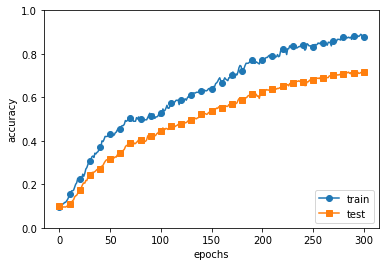

<Figure size 432x288 with 0 Axes>

In [9]:
trial(use_dropout=True, dropout_ratio=0.15) # テキストと同じ0.15

train loss:2.403446555321777
=== epoch:1, train acc:0.07333333333333333, test acc:0.1038 ===
train loss:2.37736670595611
train loss:2.330877856111378
train loss:2.3296280964704965
=== epoch:2, train acc:0.09333333333333334, test acc:0.1195 ===
train loss:2.3070252733201277
train loss:2.3249275769709987
train loss:2.2691753567664703
=== epoch:3, train acc:0.13333333333333333, test acc:0.1235 ===
train loss:2.2413634057740515
train loss:2.2048856687416354
train loss:2.258269781831598
=== epoch:4, train acc:0.2, test acc:0.1533 ===
train loss:2.156122490158655
train loss:2.1717481457302097
train loss:2.114141163636077
=== epoch:5, train acc:0.25666666666666665, test acc:0.1872 ===
train loss:2.1428397068300438
train loss:2.111112768585493
train loss:2.1103785018647887
=== epoch:6, train acc:0.2733333333333333, test acc:0.21 ===
train loss:2.0838575749183335
train loss:2.1144424089691185
train loss:2.060265679380756
=== epoch:7, train acc:0.2866666666666667, test acc:0.2124 ===
train loss:

=== epoch:57, train acc:0.94, test acc:0.7136 ===
train loss:0.31385218473606025
train loss:0.2944814447266545
train loss:0.2523091488908046
=== epoch:58, train acc:0.94, test acc:0.7263 ===
train loss:0.3063167520726839
train loss:0.3221073650141096
train loss:0.3098913950101416
=== epoch:59, train acc:0.94, test acc:0.7285 ===
train loss:0.231452620770517
train loss:0.2804189430166614
train loss:0.2048587601540945
=== epoch:60, train acc:0.95, test acc:0.7306 ===
train loss:0.25776923111650346
train loss:0.2780323090139145
train loss:0.33546693060686245
=== epoch:61, train acc:0.95, test acc:0.7321 ===
train loss:0.24767950919837453
train loss:0.25237883630766667
train loss:0.2158326500935375
=== epoch:62, train acc:0.95, test acc:0.7268 ===
train loss:0.19215294460158955
train loss:0.2185020773142319
train loss:0.20518512912219852
=== epoch:63, train acc:0.95, test acc:0.7352 ===
train loss:0.28816096434065275
train loss:0.2296871653337674
train loss:0.23905809224376123
=== epoch:64

=== epoch:114, train acc:1.0, test acc:0.7543 ===
train loss:0.0713933419710402
train loss:0.052697621613532364
train loss:0.049437810643248356
=== epoch:115, train acc:1.0, test acc:0.7565 ===
train loss:0.05313865034629605
train loss:0.054547953762678125
train loss:0.05800536894276069
=== epoch:116, train acc:1.0, test acc:0.754 ===
train loss:0.044720285955637484
train loss:0.0538556330769772
train loss:0.04827945824453634
=== epoch:117, train acc:0.9966666666666667, test acc:0.755 ===
train loss:0.06948153781107509
train loss:0.06622502609316384
train loss:0.06319323376576472
=== epoch:118, train acc:0.9966666666666667, test acc:0.754 ===
train loss:0.05901554815114606
train loss:0.06321737667051493
train loss:0.04605865711443536
=== epoch:119, train acc:0.9966666666666667, test acc:0.7559 ===
train loss:0.06127100577011874
train loss:0.08778498476994351
train loss:0.04477317122365543
=== epoch:120, train acc:1.0, test acc:0.7568 ===
train loss:0.061098452571099575
train loss:0.063

=== epoch:171, train acc:1.0, test acc:0.7654 ===
train loss:0.02479886991073087
train loss:0.02701067983425585
train loss:0.026348212436995363
=== epoch:172, train acc:1.0, test acc:0.7637 ===
train loss:0.02204786654776524
train loss:0.028978647567994963
train loss:0.02327702578165296
=== epoch:173, train acc:1.0, test acc:0.7655 ===
train loss:0.023497650922161765
train loss:0.0306964752374646
train loss:0.02364831898205216
=== epoch:174, train acc:1.0, test acc:0.7642 ===
train loss:0.02790798536928217
train loss:0.026647622846801233
train loss:0.016274716363087704
=== epoch:175, train acc:1.0, test acc:0.7638 ===
train loss:0.03070156761589607
train loss:0.028795392032264475
train loss:0.020466099834990398
=== epoch:176, train acc:1.0, test acc:0.7614 ===
train loss:0.02030841885841329
train loss:0.023212076465234145
train loss:0.02231281110900489
=== epoch:177, train acc:1.0, test acc:0.7626 ===
train loss:0.029182282966251697
train loss:0.0184538371360748
train loss:0.0267641444

=== epoch:228, train acc:1.0, test acc:0.7652 ===
train loss:0.01885419605070927
train loss:0.017535121194841612
train loss:0.01839994511763643
=== epoch:229, train acc:1.0, test acc:0.7663 ===
train loss:0.017719351500486688
train loss:0.01591105146686008
train loss:0.015295499840720596
=== epoch:230, train acc:1.0, test acc:0.7636 ===
train loss:0.016915716596275845
train loss:0.015262859303272966
train loss:0.01899773260131375
=== epoch:231, train acc:1.0, test acc:0.7661 ===
train loss:0.014627453026152917
train loss:0.00974294510784097
train loss:0.013975397279163644
=== epoch:232, train acc:1.0, test acc:0.7659 ===
train loss:0.011885410253454845
train loss:0.012332048489474673
train loss:0.010850255663416925
=== epoch:233, train acc:1.0, test acc:0.7653 ===
train loss:0.014667337038931699
train loss:0.010192993962051746
train loss:0.01779850209794944
=== epoch:234, train acc:1.0, test acc:0.7658 ===
train loss:0.014078029495418304
train loss:0.015340208520079168
train loss:0.014

=== epoch:285, train acc:1.0, test acc:0.768 ===
train loss:0.012317373726847873
train loss:0.008702905998713165
train loss:0.008915357174307062
=== epoch:286, train acc:1.0, test acc:0.7687 ===
train loss:0.009665773271616763
train loss:0.010570849876114286
train loss:0.008503962423280888
=== epoch:287, train acc:1.0, test acc:0.768 ===
train loss:0.007863948574105271
train loss:0.009297619957353728
train loss:0.009326681233302311
=== epoch:288, train acc:1.0, test acc:0.7679 ===
train loss:0.009009133589802593
train loss:0.00872766540029152
train loss:0.007654104498017298
=== epoch:289, train acc:1.0, test acc:0.7674 ===
train loss:0.011522949962167843
train loss:0.0095284976696316
train loss:0.011120777883280928
=== epoch:290, train acc:1.0, test acc:0.7679 ===
train loss:0.009586568315100652
train loss:0.008835943954983352
train loss:0.009902880871643156
=== epoch:291, train acc:1.0, test acc:0.7681 ===
train loss:0.010541730296408529
train loss:0.009775003704458418
train loss:0.01

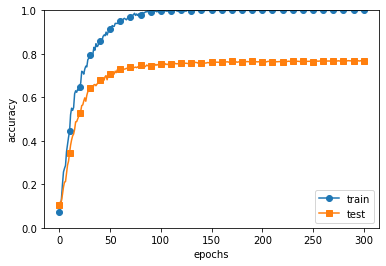

<Figure size 432x288 with 0 Axes>

In [10]:
trial(use_dropout=False, dropout_ratio=0.15) #dropoutを使わない場合

### 結果まとめ


1. trial(use_dropout=True, dropout_ratio=0.2)の場合、訓練データとテストデータの差は小さくなっているものの、テストデータの場合の正解率が0.4程度(0.4682)と低めになっている。これは、dropout_ratioが高すぎなのだろう
2. trial(use_dropout=True, dropout_ratio=0.15)の場合、訓練データとテストデータの差は開き始めたが、今度はテストデータの場合の正解率が上がり、0.7212となっている。
3. trial(use_dropout=False, dropout_ratio=0.2)の場合、明らかに過学習が発生しているが、テストデータの正解率が0.769であり、これらの試行で一番高い値を示している。

ここまでの結果を見ると、Dropoutを使わないほうが、テストデータに対する正解率が高いような気がする。。。

train loss:2.303468036580703
=== epoch:1, train acc:0.11, test acc:0.0947 ===
train loss:2.3018915441842527
train loss:2.3029688016001804
train loss:2.301923138179282
=== epoch:2, train acc:0.10333333333333333, test acc:0.0886 ===
train loss:2.3004292505025505
train loss:2.3003166265069694
train loss:2.3018130936616474
=== epoch:3, train acc:0.09666666666666666, test acc:0.0844 ===
train loss:2.3019925188620443
train loss:2.3020742163798924
train loss:2.3023687813709937
=== epoch:4, train acc:0.10666666666666667, test acc:0.0851 ===
train loss:2.302572936494491
train loss:2.3019458626906193
train loss:2.3008692383281426
=== epoch:5, train acc:0.11, test acc:0.0868 ===
train loss:2.302416474010892
train loss:2.302155005525942
train loss:2.3006666002488707
=== epoch:6, train acc:0.11, test acc:0.0887 ===
train loss:2.3015194551864364
train loss:2.300608274392026
train loss:2.30137794766032
=== epoch:7, train acc:0.13333333333333333, test acc:0.1206 ===
train loss:2.3016346531728096
train

=== epoch:61, train acc:0.13, test acc:0.1135 ===
train loss:2.293190795924474
train loss:2.294773784975934
train loss:2.2933650697327725
=== epoch:62, train acc:0.13, test acc:0.1135 ===
train loss:2.2951304632350182
train loss:2.299967938639077
train loss:2.2975595140080505
=== epoch:63, train acc:0.13, test acc:0.1135 ===
train loss:2.29814740770441
train loss:2.300554199581444
train loss:2.2986016436393157
=== epoch:64, train acc:0.13, test acc:0.1135 ===
train loss:2.2993830679994023
train loss:2.29406804211787
train loss:2.299546635203419
=== epoch:65, train acc:0.13, test acc:0.1135 ===
train loss:2.2999702107698665
train loss:2.293755313584101
train loss:2.299940433057974
=== epoch:66, train acc:0.13, test acc:0.1135 ===
train loss:2.292636173360142
train loss:2.2969441215094606
train loss:2.294522297945267
=== epoch:67, train acc:0.13, test acc:0.1135 ===
train loss:2.292187751158157
train loss:2.3037423770550696
train loss:2.29495547050982
=== epoch:68, train acc:0.13, test a

=== epoch:121, train acc:0.13, test acc:0.1135 ===
train loss:2.294370299757226
train loss:2.2923795761896866
train loss:2.29663631556619
=== epoch:122, train acc:0.13, test acc:0.1135 ===
train loss:2.2936339232569414
train loss:2.2990791514570734
train loss:2.297511554409169
=== epoch:123, train acc:0.13, test acc:0.1135 ===
train loss:2.297824911067822
train loss:2.2919447292127284
train loss:2.299130314040899
=== epoch:124, train acc:0.13, test acc:0.1135 ===
train loss:2.2932905638326484
train loss:2.289264549666586
train loss:2.288975708654996
=== epoch:125, train acc:0.13, test acc:0.1135 ===
train loss:2.3039608774610123
train loss:2.2913270773377126
train loss:2.2858073224614435
=== epoch:126, train acc:0.13, test acc:0.1135 ===
train loss:2.296915195635377
train loss:2.2907681295426556
train loss:2.2892798323434405
=== epoch:127, train acc:0.13, test acc:0.1135 ===
train loss:2.297489388847126
train loss:2.2869676813157933
train loss:2.292348771802639
=== epoch:128, train acc

=== epoch:182, train acc:0.13, test acc:0.1135 ===
train loss:2.273483959254552
train loss:2.296221768234012
train loss:2.2795121601989052
=== epoch:183, train acc:0.13, test acc:0.1135 ===
train loss:2.3056724921507232
train loss:2.290625996341475
train loss:2.305395759780495
=== epoch:184, train acc:0.13, test acc:0.1135 ===
train loss:2.2960788771822553
train loss:2.2906929094747586
train loss:2.296116016542239
=== epoch:185, train acc:0.13, test acc:0.1135 ===
train loss:2.3028007847443543
train loss:2.284896596899362
train loss:2.280139148052283
=== epoch:186, train acc:0.13, test acc:0.1135 ===
train loss:2.282982251333235
train loss:2.2947083092327105
train loss:2.295833104856554
=== epoch:187, train acc:0.13, test acc:0.1135 ===
train loss:2.280501750602932
train loss:2.2857659963995154
train loss:2.307224039204905
=== epoch:188, train acc:0.13, test acc:0.1135 ===
train loss:2.2954915197952612
train loss:2.2925940933011235
train loss:2.296147343772317
=== epoch:189, train acc:

train loss:2.313497592368273
=== epoch:241, train acc:0.13, test acc:0.1135 ===
train loss:2.3063057695555136
train loss:2.294993845700592
train loss:2.2878614813301428
=== epoch:242, train acc:0.13, test acc:0.1135 ===
train loss:2.2751770187520055
train loss:2.292799628808438
train loss:2.2894396836775446
=== epoch:243, train acc:0.13, test acc:0.1135 ===
train loss:2.2950153901692016
train loss:2.297286478431977
train loss:2.2827522836167953
=== epoch:244, train acc:0.13, test acc:0.1135 ===
train loss:2.305415690148585
train loss:2.288070740433034
train loss:2.310676257879845
=== epoch:245, train acc:0.13, test acc:0.1135 ===
train loss:2.3007620260163497
train loss:2.2942571998439067
train loss:2.3067655160978457
=== epoch:246, train acc:0.13, test acc:0.1135 ===
train loss:2.271697156526628
train loss:2.2830754054067457
train loss:2.288659592467233
=== epoch:247, train acc:0.13, test acc:0.1135 ===
train loss:2.2849704524788255
train loss:2.2937643653916777
train loss:2.295538053

=== epoch:301, train acc:0.13, test acc:0.1135 ===
train loss:2.2717890204327036
train loss:2.284358831727542
=============== Final Test Accuracy ===============
test acc:0.1135


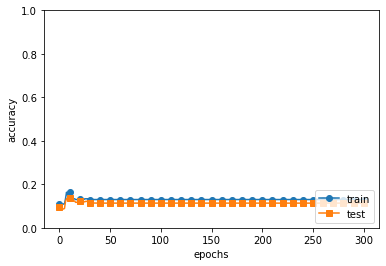

<Figure size 432x288 with 0 Axes>

In [11]:
#遊びで、dropout_ratioが極端に高い場合を２例
trial(use_dropout=True, dropout_ratio=0.5) 

train loss:2.3024271042392277
=== epoch:1, train acc:0.10666666666666667, test acc:0.0982 ===
train loss:2.302404353926786
train loss:2.302564911405997
train loss:2.302333440890149
=== epoch:2, train acc:0.10666666666666667, test acc:0.0982 ===
train loss:2.3022444831633426
train loss:2.302466376934317
train loss:2.302320257728447
=== epoch:3, train acc:0.13, test acc:0.1135 ===
train loss:2.302230819723866
train loss:2.302266720181889
train loss:2.3020863567871914
=== epoch:4, train acc:0.10333333333333333, test acc:0.1009 ===
train loss:2.3022339313106075
train loss:2.302115423997999
train loss:2.302395420061067
=== epoch:5, train acc:0.11333333333333333, test acc:0.101 ===
train loss:2.3020631913506886
train loss:2.3020625578933993
train loss:2.301671073376626
=== epoch:6, train acc:0.13, test acc:0.1135 ===
train loss:2.301893538312859
train loss:2.301811920518744
train loss:2.3024787423738933
=== epoch:7, train acc:0.13, test acc:0.1135 ===
train loss:2.3022087268669096
train loss

=== epoch:60, train acc:0.13, test acc:0.1135 ===
train loss:2.2967544371650304
train loss:2.2968488998799357
train loss:2.3006711214929383
=== epoch:61, train acc:0.13, test acc:0.1135 ===
train loss:2.3000958476968436
train loss:2.299800964161025
train loss:2.2996582996148502
=== epoch:62, train acc:0.13, test acc:0.1135 ===
train loss:2.296167237927327
train loss:2.3000588629253866
train loss:2.3029745817516725
=== epoch:63, train acc:0.13, test acc:0.1135 ===
train loss:2.2995347639071775
train loss:2.302642031488735
train loss:2.298863232054889
=== epoch:64, train acc:0.13, test acc:0.1135 ===
train loss:2.298310344359558
train loss:2.294158138874757
train loss:2.3014760650747514
=== epoch:65, train acc:0.13, test acc:0.1135 ===
train loss:2.30036910409893
train loss:2.2979064017911326
train loss:2.293094636041616
=== epoch:66, train acc:0.13, test acc:0.1135 ===
train loss:2.2972831994775063
train loss:2.294411904502393
train loss:2.293883935980971
=== epoch:67, train acc:0.13, t

=== epoch:120, train acc:0.13, test acc:0.1135 ===
train loss:2.3064675722602543
train loss:2.295121873642679
train loss:2.28840678548444
=== epoch:121, train acc:0.13, test acc:0.1135 ===
train loss:2.298229496248158
train loss:2.299337592530497
train loss:2.2933774045184414
=== epoch:122, train acc:0.13, test acc:0.1135 ===
train loss:2.290316512976953
train loss:2.2977459853909235
train loss:2.3025936387451877
=== epoch:123, train acc:0.13, test acc:0.1135 ===
train loss:2.294159402074753
train loss:2.299725086593022
train loss:2.293184936038452
=== epoch:124, train acc:0.13, test acc:0.1135 ===
train loss:2.2949425368027274
train loss:2.2961251258159097
train loss:2.2974384254936693
=== epoch:125, train acc:0.13, test acc:0.1135 ===
train loss:2.292448402577312
train loss:2.29127077172556
train loss:2.2958087594691414
=== epoch:126, train acc:0.13, test acc:0.1135 ===
train loss:2.302083609343977
train loss:2.3107979155934117
train loss:2.295488572946459
=== epoch:127, train acc:0.

=== epoch:179, train acc:0.13, test acc:0.1135 ===
train loss:2.2908049091302445
train loss:2.3000297389986977
train loss:2.2828063421566793
=== epoch:180, train acc:0.13, test acc:0.1135 ===
train loss:2.293161502691601
train loss:2.2964264474122116
train loss:2.30751959727578
=== epoch:181, train acc:0.13, test acc:0.1135 ===
train loss:2.2902225816462876
train loss:2.289915498534274
train loss:2.295486794965727
=== epoch:182, train acc:0.13, test acc:0.1135 ===
train loss:2.289885372585765
train loss:2.28791605167248
train loss:2.284256892924044
=== epoch:183, train acc:0.13, test acc:0.1135 ===
train loss:2.3001749343321025
train loss:2.2863696761764927
train loss:2.2863812068938514
=== epoch:184, train acc:0.13, test acc:0.1135 ===
train loss:2.291675995336345
train loss:2.30154852110672
train loss:2.27878083453762
=== epoch:185, train acc:0.13, test acc:0.1135 ===
train loss:2.2914697853339496
train loss:2.291503778222453
train loss:2.29593912111428
=== epoch:186, train acc:0.13,

=== epoch:239, train acc:0.13, test acc:0.1135 ===
train loss:2.2912758103818898
train loss:2.287698332498569
train loss:2.2961273640735986
=== epoch:240, train acc:0.13, test acc:0.1135 ===
train loss:2.2853646578066353
train loss:2.2826518943673806
train loss:2.290922727458935
=== epoch:241, train acc:0.13, test acc:0.1135 ===
train loss:2.293718411610709
train loss:2.3022946040890035
train loss:2.2988873423494063
=== epoch:242, train acc:0.13, test acc:0.1135 ===
train loss:2.300677969674131
train loss:2.2892380255970384
train loss:2.2896873759419476
=== epoch:243, train acc:0.13, test acc:0.1135 ===
train loss:2.292840562049453
train loss:2.3034359863214164
train loss:2.3052370088258924
=== epoch:244, train acc:0.13, test acc:0.1135 ===
train loss:2.292103164665946
train loss:2.2898014903150403
train loss:2.3127982810195307
=== epoch:245, train acc:0.13, test acc:0.1135 ===
train loss:2.2915422572872286
train loss:2.2918236666800986
train loss:2.291738648000923
=== epoch:246, train

=== epoch:298, train acc:0.13, test acc:0.1135 ===
train loss:2.2933995851870823
train loss:2.292947337007985
train loss:2.2801789688352945
=== epoch:299, train acc:0.13, test acc:0.1135 ===
train loss:2.2808463309529627
train loss:2.2972485206823574
train loss:2.291199750925014
=== epoch:300, train acc:0.13, test acc:0.1135 ===
train loss:2.29739190720718
train loss:2.302129172919417
train loss:2.2824337421076013
=== epoch:301, train acc:0.13, test acc:0.1135 ===
train loss:2.286336062982447
train loss:2.2994488723258386
=============== Final Test Accuracy ===============
test acc:0.1135


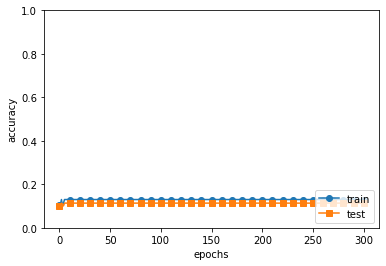

<Figure size 432x288 with 0 Axes>

In [12]:
#遊びで、dropout_ratioが極端に高い場合を２例
trial(use_dropout=True, dropout_ratio=0.9) 